In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 93% 161M/172M [00:01<00:00, 116MB/s]
100% 172M/172M [00:01<00:00, 101MB/s]


In [ ]:
!unzip augmented-forest-segmentation.zip


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segment

In [ ]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(23)

In [ ]:
## resizing images
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

In [ ]:
image_path = "/content/Forest Segmented/Forest Segmented/images/*.jpg"
mask_path = "/content/Forest Segmented/Forest Segmented/masks/*.jpg"

In [ ]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [ ]:
image_names

['/content/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg',
 '/content/Forest Segmented/Forest Segmented/images/10452_sat_18.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_00.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_01.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_02.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_03.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_04.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_07.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_08.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_10.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_12.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_13.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_15.jpg',
 '/content/Forest Segmented/Forest Segmented/images/111335_sat_23.

In [ ]:
image_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    image_array.append(img)

image_array = np.array(image_array)

In [ ]:
mask_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_array.append(msk)

mask_array = np.array(mask_array)

In [ ]:
num = random.randint(0,100)
print(f"Random image array element: {image_array[num]}\n")
print(f"Image shape: {image_array[num].shape}\n")

print(f"Random mask array element: {mask_array[num]}\n")
print(f"Mask shape: {mask_array[num].shape}\n")

print(f"Image array length: {len(image_array)}\n")
print(f"Mask array length: {len(mask_array)}\n")

Random image array element: [[[141 171 186]
  [110 141 158]
  [113 140 155]
  ...
  [ 62  84  89]
  [ 63  84  86]
  [ 65  83  84]]

 [[155 186 200]
  [108 141 157]
  [105 133 146]
  ...
  [ 64  86  91]
  [ 64  84  87]
  [ 62  79  81]]

 [[139 169 180]
  [111 143 157]
  [100 128 140]
  ...
  [ 66  85  91]
  [ 72  91  95]
  [ 45  62  65]]

 ...

 [[ 53  80  77]
  [ 68  94  88]
  [ 84 110  98]
  ...
  [ 59  77  64]
  [ 47  67  53]
  [ 61  80  64]]

 [[ 41  65  70]
  [ 69  92  91]
  [ 72  95  90]
  ...
  [ 48  69  54]
  [ 55  77  60]
  [ 61  83  63]]

 [[ 31  54  63]
  [ 57  77  81]
  [ 68  89  87]
  ...
  [ 61  83  67]
  [ 55  77  58]
  [ 64  88  65]]]

Image shape: (128, 128, 3)

Random mask array element: [[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

Mask shape: (128, 128)

Image array length: 5108

Mask array length: 5108



In [ ]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(image_array)
y = normalize_array(mask_array)

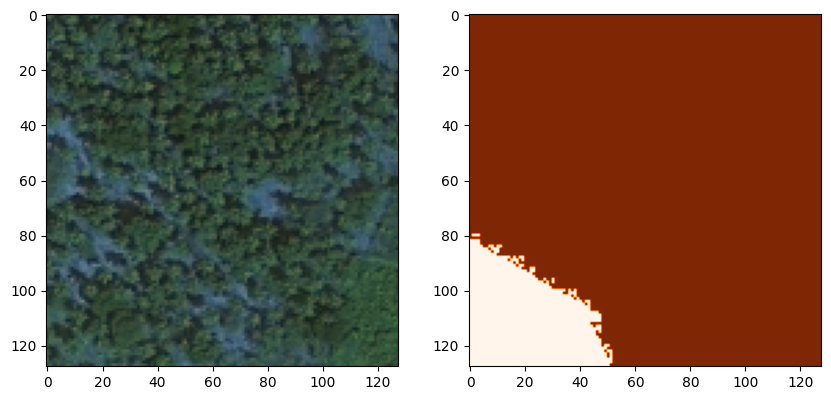

In [ ]:
random_number = random.randint(0,500)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X[random_number])


cmap = plt.get_cmap('Oranges_r')
masked_region = (y[random_number] != 1).astype(float)
ax[1].imshow(masked_region, cmap=cmap)

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=23)

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [ ]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
model = unet_model(n_filters=32,input_size=(128,128,3))

## let's use loss as binary_crossentropy since we have only two output fields: forest area and non-forest area
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
num_epochs = 30

history = model.fit(X_train,y_train,epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/30
144/144 [==============================] - 66s 297ms/step - loss: 0.5808 - accuracy: 0.7006 - val_loss: 0.5845 - val_accuracy: 0.7058
Epoch 2/30
144/144 [==============================] - 31s 213ms/step - loss: 0.5452 - accuracy: 0.7296 - val_loss: 0.5040 - val_accuracy: 0.7609
Epoch 3/30
144/144 [==============================] - 31s 213ms/step - loss: 0.6252 - accuracy: 0.6752 - val_loss: 0.5666 - val_accuracy: 0.7052
Epoch 4/30
144/144 [==============================] - 30s 207ms/step - loss: 0.5182 - accuracy: 0.7473 - val_loss: 0.4784 - val_accuracy: 0.7702
Epoch 5/30
144/144 [==============================] - 30s 212ms/step - loss: 0.4940 - accuracy: 0.7638 - val_loss: 0.4585 - val_accuracy: 0.7874
Epoch 6/30
144/144 [==============================] - 30s 207ms/step - loss: 0.4765 - accuracy: 0.7731 - val_loss: 0.4627 - val_accuracy: 0.7724
Epoch 7/30
144/144 [==============================] - 30s 211ms/step - loss: 0.4650 - accuracy: 0.7769 - val_loss: 0.4417 - val_ac

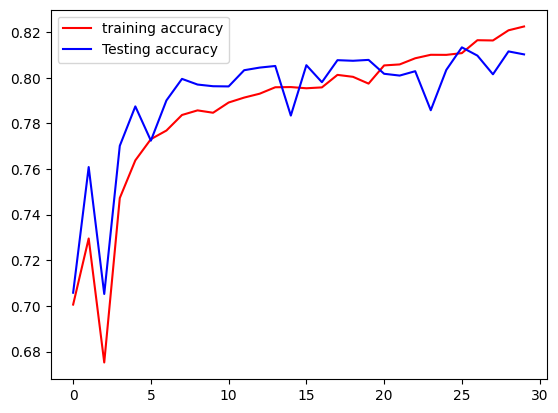

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='Testing accuracy')
plt.legend()
plt.show()

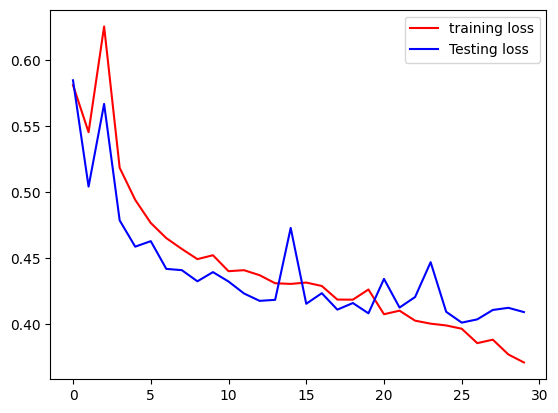

In [ ]:
plt.plot(history.history['loss'],color='red',label='training loss')
plt.plot(history.history['val_loss'],color='blue',label='Testing loss')
plt.legend()
plt.show()

In [ ]:
model.save('my_unet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
